### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
np.random.seed(5)
import time
import sys

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params, keep_prob):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    a1_c = tf.nn.dropout(a1_c, keep_prob, seed=2)
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
    a1_p = tf.nn.dropout(a1_p, keep_prob, seed=2)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    a2_c = tf.nn.dropout(a2_c, keep_prob, seed=2)
    
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    a2_p = tf.nn.dropout(a2_p, keep_prob, seed=2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    a4 = tf.nn.dropout(a4, keep_prob, seed=2)
    print(a4)
    
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 4
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 4
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [ ]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params, keep_prob)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            old_cost = new_cost
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            new_cost = epoch_cost
            cost_history.append(epoch_cost)
            if(abs(old_cost - new_cost) < 0.00000000001):
                print("breaking" + str(old_cost) + str(new_cost))
                break;
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        print('Learning rate: ' , learning_rate)
        print('Keep probability: ' , keep_prob)
        elapsed_time = time.time() - start_time
        print("Time elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

**********Learning rate******0.011********Keep prob***********0.7
Instructions for updating:
Use the retry module or similar alternatives.
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.21666666865348816
Accuracy Test: 0.21666667 on iteration 1
Cost is 1.7887497 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.7582229 for iteration: 2
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 3
Cost is 1.791824 for itera

Accuracy Test: 0.8333333 on iteration 84
Cost is 1.1797249 for iteration: 84
Max till now is  0.8500000238418579
Accuracy Test: 0.85 on iteration 85
Cost is 1.1656088 for iteration: 85
Accuracy Test: 0.8111111 on iteration 86
Cost is 1.1768845 for iteration: 86
Accuracy Test: 0.8277778 on iteration 87
Cost is 1.1758163 for iteration: 87
Accuracy Test: 0.8277778 on iteration 88
Cost is 1.1738194 for iteration: 88
Accuracy Test: 0.82222223 on iteration 89
Cost is 1.1677518 for iteration: 89
Accuracy Test: 0.8388889 on iteration 90
Cost is 1.1645738 for iteration: 90
Accuracy Test: 0.81666666 on iteration 91
Cost is 1.1713529 for iteration: 91
Accuracy Test: 0.8 on iteration 92
Cost is 1.1614211 for iteration: 92
Accuracy Test: 0.8388889 on iteration 93
Cost is 1.1690925 for iteration: 93
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 94
Cost is 1.1630133 for iteration: 94
Accuracy Test: 0.85 on iteration 95
Cost is 1.1640779 for iteration: 95
Accuracy Test: 0.8

Accuracy Test: 0.90555555 on iteration 185
Cost is 1.1086811 for iteration: 185
Accuracy Test: 0.8833333 on iteration 186
Cost is 1.1020998 for iteration: 186
Accuracy Test: 0.8666667 on iteration 187
Cost is 1.1033541 for iteration: 187
Accuracy Test: 0.8666667 on iteration 188
Cost is 1.0983815 for iteration: 188
Accuracy Test: 0.87222224 on iteration 189
Cost is 1.0976359 for iteration: 189
Accuracy Test: 0.90555555 on iteration 190
Cost is 1.1033207 for iteration: 190
Accuracy Test: 0.87777776 on iteration 191
Cost is 1.1050587 for iteration: 191
Accuracy Test: 0.84444445 on iteration 192
Cost is 1.1052347 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.1074845 for iteration: 193
Max till now is  0.9222221970558167
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.1147122 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0945629 for iteration: 195
Accuracy Test: 0.8833333 on iteration 196
Cost is 1.097674 for iteration: 196
Accuracy T

Accuracy Test: 0.9166667 on iteration 288
Cost is 1.0797925 for iteration: 288
Accuracy Test: 0.93333334 on iteration 289
Cost is 1.0802426 for iteration: 289
Accuracy Test: 0.8888889 on iteration 290
Cost is 1.0782208 for iteration: 290
Accuracy Test: 0.90555555 on iteration 291
Cost is 1.0782179 for iteration: 291
Accuracy Test: 0.9166667 on iteration 292
Cost is 1.0696158 for iteration: 292
Accuracy Test: 0.92777777 on iteration 293
Cost is 1.0753757 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0722758 for iteration: 294
Accuracy Test: 0.9222222 on iteration 295
Cost is 1.0735754 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0806652 for iteration: 296
Accuracy Test: 0.90555555 on iteration 297
Cost is 1.0721194 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0798014 for iteration: 298
Accuracy Test: 0.9 on iteration 299
Cost is 1.0816007 for iteration: 299
Accuracy Test: 0.9388889 on iteration 300
Cost is 1.

Accuracy Test: 0.9388889 on iteration 393
Cost is 1.0729852 for iteration: 393
Accuracy Test: 0.92777777 on iteration 394
Cost is 1.0640434 for iteration: 394
Accuracy Test: 0.9166667 on iteration 395
Cost is 1.0752459 for iteration: 395
Accuracy Test: 0.9166667 on iteration 396
Cost is 1.0704788 for iteration: 396
Accuracy Test: 0.9 on iteration 397
Cost is 1.0730846 for iteration: 397
Accuracy Test: 0.9222222 on iteration 398
Cost is 1.0831296 for iteration: 398
Accuracy Test: 0.9444444 on iteration 399
Cost is 1.075528 for iteration: 399
Accuracy Test: 0.89444447 on iteration 400
Cost is 1.0706292 for iteration: 400
Accuracy Test: 0.90555555 on iteration 401
Cost is 1.0867265 for iteration: 401
Accuracy Test: 0.9166667 on iteration 402
Cost is 1.0776827 for iteration: 402
Accuracy Test: 0.92777777 on iteration 403
Cost is 1.0754437 for iteration: 403
Accuracy Test: 0.87777776 on iteration 404
Cost is 1.0862664 for iteration: 404
Accuracy Test: 0.93333334 on iteration 405
Cost is 1.0

Accuracy Test: 0.9222222 on iteration 497
Cost is 1.0692811 for iteration: 497
Accuracy Test: 0.9166667 on iteration 498
Cost is 1.0838579 for iteration: 498
Accuracy Test: 0.9222222 on iteration 499
Cost is 1.0733312 for iteration: 499
Accuracy Test: 0.8888889 on iteration 500
Cost is 1.0753698 for iteration: 500


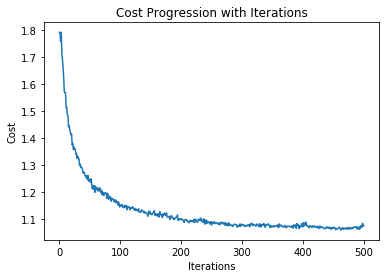

Train Accuracy:  95.98039388656616
Test Accuracy:  88.88888955116272
Max Test Accuracy: 95.55555582046509 on iteration 479
Learning rate:  0.011
Keep probability:  0.7
Time elapsed :  11.634387199083964
**********Learning rate******0.011********Keep prob***********0.8
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7918481 for iteration: 0
Accuracy Test: 0.17222223 on iteration 1
Cost is 1.7823824 for iteration: 1
Accuracy Test: 0.15555556 on iteration 2
Cost is 1.7733799 for iteration: 2
Max

Accuracy Test: 0.8277778 on iteration 84
Cost is 1.1565589 for iteration: 84
Accuracy Test: 0.8388889 on iteration 85
Cost is 1.1608049 for iteration: 85
Accuracy Test: 0.8277778 on iteration 86
Cost is 1.150373 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.1485922 for iteration: 87
Accuracy Test: 0.81666666 on iteration 88
Cost is 1.1478962 for iteration: 88
Accuracy Test: 0.8388889 on iteration 89
Cost is 1.1631566 for iteration: 89
Accuracy Test: 0.85555553 on iteration 90
Cost is 1.1498297 for iteration: 90
Accuracy Test: 0.85 on iteration 91
Cost is 1.1464992 for iteration: 91
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1469356 for iteration: 92
Accuracy Test: 0.8333333 on iteration 93
Cost is 1.1429708 for iteration: 93
Accuracy Test: 0.82222223 on iteration 94
Cost is 1.1390183 for iteration: 94
Accuracy Test: 0.85555553 on iteration 95
Cost is 1.1369799 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1351316 for iteration: 96

Accuracy Test: 0.8888889 on iteration 186
Cost is 1.0888633 for iteration: 186
Accuracy Test: 0.90555555 on iteration 187
Cost is 1.0869638 for iteration: 187
Accuracy Test: 0.92777777 on iteration 188
Cost is 1.0786577 for iteration: 188
Accuracy Test: 0.89444447 on iteration 189
Cost is 1.084881 for iteration: 189
Accuracy Test: 0.8888889 on iteration 190
Cost is 1.0833575 for iteration: 190
Accuracy Test: 0.85555553 on iteration 191
Cost is 1.0842217 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.0876322 for iteration: 192
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 193
Cost is 1.0800833 for iteration: 193
Accuracy Test: 0.93333334 on iteration 194
Cost is 1.0815445 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0806079 for iteration: 195
Accuracy Test: 0.9166667 on iteration 196
Cost is 1.0821859 for iteration: 196
Accuracy Test: 0.9111111 on iteration 197
Cost is 1.0774299 for iteration: 197
Accuracy Tes

Accuracy Test: 0.9111111 on iteration 290
Cost is 1.0624921 for iteration: 290
Accuracy Test: 0.9166667 on iteration 291
Cost is 1.062896 for iteration: 291
Accuracy Test: 0.9222222 on iteration 292
Cost is 1.0660799 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.063673 for iteration: 293
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 294
Cost is 1.0617137 for iteration: 294
Accuracy Test: 0.9444444 on iteration 295
Cost is 1.0659072 for iteration: 295
Accuracy Test: 0.93333334 on iteration 296
Cost is 1.0662315 for iteration: 296
Accuracy Test: 0.9388889 on iteration 297
Cost is 1.0613102 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.063148 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.0618966 for iteration: 299
Max till now is  0.9611111283302307
Accuracy Test: 0.9611111 on iteration 300
Cost is 1.0606524 for iteration: 300
Accuracy Test: 0.90555555 on iteration 301
Cost is 1.0642531 for i

Accuracy Test: 0.9222222 on iteration 393
Cost is 1.055498 for iteration: 393
Accuracy Test: 0.93333334 on iteration 394
Cost is 1.0614384 for iteration: 394
Accuracy Test: 0.92777777 on iteration 395
Cost is 1.0590204 for iteration: 395
Accuracy Test: 0.9444444 on iteration 396
Cost is 1.0622004 for iteration: 396
Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0591545 for iteration: 397
Accuracy Test: 0.9444444 on iteration 398
Cost is 1.0631491 for iteration: 398
Accuracy Test: 0.9388889 on iteration 399
Cost is 1.0572449 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.0560861 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0578668 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.0554005 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.057128 for iteration: 403
Accuracy Test: 0.9444444 on iteration 404
Cost is 1.0567646 for iteration: 404
Accuracy Test: 0.9444444 on iteration 405
Cost is 1.056

Accuracy Test: 0.95 on iteration 498
Cost is 1.0519948 for iteration: 498
Accuracy Test: 0.9222222 on iteration 499
Cost is 1.0532835 for iteration: 499
Accuracy Test: 0.9444444 on iteration 500
Cost is 1.0539002 for iteration: 500


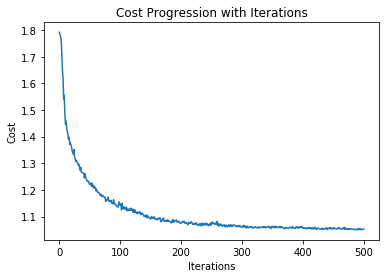

Train Accuracy:  98.92156720161438
Test Accuracy:  94.44444179534912
Max Test Accuracy: 96.66666388511658 on iteration 387
Learning rate:  0.011
Keep probability:  0.8
Time elapsed :  10.8982790350914
**********Learning rate******0.011********Keep prob***********0.9
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920426 for iteration: 0
Accuracy Test: 0.2 on iteration 1
Cost is 1.7858785 for iteration: 1
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 2
Cost is 1.7

Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1308842 for iteration: 88
Accuracy Test: 0.8666667 on iteration 89
Cost is 1.125375 for iteration: 89
Accuracy Test: 0.82222223 on iteration 90
Cost is 1.126342 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.1243241 for iteration: 91
Accuracy Test: 0.8666667 on iteration 92
Cost is 1.1380947 for iteration: 92
Accuracy Test: 0.82222223 on iteration 93
Cost is 1.1193 for iteration: 93
Accuracy Test: 0.87222224 on iteration 94
Cost is 1.1220943 for iteration: 94
Accuracy Test: 0.84444445 on iteration 95
Cost is 1.1169759 for iteration: 95
Accuracy Test: 0.85555553 on iteration 96
Cost is 1.1204333 for iteration: 96
Accuracy Test: 0.85 on iteration 97
Cost is 1.1181444 for iteration: 97
Accuracy Test: 0.85555553 on iteration 98
Cost is 1.1256871 for iteration: 98
Max till now is  0.8888888955116272
Accuracy Test: 0.8888889 on iteration 99
Cost is 1.10955 for iteration: 99
Accuracy Test: 0.87777776 on iteration 100
Cos

Accuracy Test: 0.90555555 on iteration 191
Cost is 1.066522 for iteration: 191
Accuracy Test: 0.8888889 on iteration 192
Cost is 1.0664915 for iteration: 192
Accuracy Test: 0.87777776 on iteration 193
Cost is 1.0662336 for iteration: 193
Accuracy Test: 0.90555555 on iteration 194
Cost is 1.0711509 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0650986 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0711099 for iteration: 196
Accuracy Test: 0.9111111 on iteration 197
Cost is 1.066217 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0661294 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0652214 for iteration: 199
Max till now is  0.9277777671813965
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0681534 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.0624969 for iteration: 201
Accuracy Test: 0.9166667 on iteration 202
Cost is 1.0659738 for iteration: 202
Accuracy Test:

Accuracy Test: 0.9222222 on iteration 294
Cost is 1.0583355 for iteration: 294
Accuracy Test: 0.9166667 on iteration 295
Cost is 1.0571548 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0575755 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0575254 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.054221 for iteration: 298
Accuracy Test: 0.9111111 on iteration 299
Cost is 1.056411 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0575255 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0538824 for iteration: 301
Accuracy Test: 0.92777777 on iteration 302
Cost is 1.0570822 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0530766 for iteration: 303
Accuracy Test: 0.9222222 on iteration 304
Cost is 1.0583898 for iteration: 304
Accuracy Test: 0.9388889 on iteration 305
Cost is 1.057981 for iteration: 305
Accuracy Test: 0.93333334 on iteration 306
Cost is 1.

Accuracy Test: 0.92777777 on iteration 398
Cost is 1.0536207 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0533681 for iteration: 399
Accuracy Test: 0.9222222 on iteration 400
Cost is 1.0513772 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0511857 for iteration: 401
Accuracy Test: 0.9111111 on iteration 402
Cost is 1.0503926 for iteration: 402
Accuracy Test: 0.9111111 on iteration 403
Cost is 1.0529115 for iteration: 403
Accuracy Test: 0.92777777 on iteration 404
Cost is 1.0518098 for iteration: 404
Accuracy Test: 0.9222222 on iteration 405
Cost is 1.0514841 for iteration: 405
Accuracy Test: 0.92777777 on iteration 406
Cost is 1.0520031 for iteration: 406
Accuracy Test: 0.90555555 on iteration 407
Cost is 1.0528238 for iteration: 407
Accuracy Test: 0.8888889 on iteration 408
Cost is 1.0520967 for iteration: 408
Accuracy Test: 0.8888889 on iteration 409
Cost is 1.057387 for iteration: 409
Accuracy Test: 0.9388889 on iteration 410
Cost 

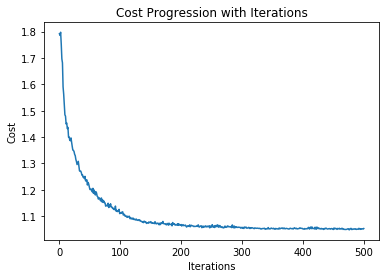

Train Accuracy:  99.41176176071167
Test Accuracy:  92.77777671813965
Max Test Accuracy: 96.11111283302307 on iteration 490
Learning rate:  0.011
Keep probability:  0.9
Time elapsed :  11.071449033419292
**********Learning rate******0.009********Keep prob***********0.7
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.2222222238779068
Accuracy Test: 0.22222222 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.2944444417953491
Accuracy Test: 0.29444444 on iteration 1
Cost is 1.783751 for iteration: 1
Accuracy Test: 0.20555556 on iteration 2
Cost

Accuracy Test: 0.8 on iteration 85
Cost is 1.1724646 for iteration: 85
Accuracy Test: 0.8 on iteration 86
Cost is 1.1693174 for iteration: 86
Accuracy Test: 0.8 on iteration 87
Cost is 1.1686809 for iteration: 87
Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 88
Cost is 1.1725565 for iteration: 88
Accuracy Test: 0.85 on iteration 89
Cost is 1.1649847 for iteration: 89
Accuracy Test: 0.8055556 on iteration 90
Cost is 1.1722041 for iteration: 90
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.1723684 for iteration: 91
Accuracy Test: 0.84444445 on iteration 92
Cost is 1.1766938 for iteration: 92
Accuracy Test: 0.8111111 on iteration 93
Cost is 1.1718092 for iteration: 93
Accuracy Test: 0.85555553 on iteration 94
Cost is 1.1686925 for iteration: 94
Accuracy Test: 0.8111111 on iteration 95
Cost is 1.164561 for iteration: 95
Accuracy Test: 0.8111111 on iteration 96
Cost is 1.1704019 for iteration: 96
Accuracy Test: 0.82222223 

Accuracy Test: 0.90555555 on iteration 187
Cost is 1.1028378 for iteration: 187
Accuracy Test: 0.8666667 on iteration 188
Cost is 1.1149808 for iteration: 188
Accuracy Test: 0.8611111 on iteration 189
Cost is 1.1002197 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.116715 for iteration: 190
Accuracy Test: 0.87777776 on iteration 191
Cost is 1.1052499 for iteration: 191
Accuracy Test: 0.8666667 on iteration 192
Cost is 1.1099025 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.1085286 for iteration: 193
Accuracy Test: 0.90555555 on iteration 194
Cost is 1.1081069 for iteration: 194
Max till now is  0.9166666865348816
Accuracy Test: 0.9166667 on iteration 195
Cost is 1.095393 for iteration: 195
Accuracy Test: 0.8666667 on iteration 196
Cost is 1.1002955 for iteration: 196
Accuracy Test: 0.8666667 on iteration 197
Cost is 1.0998809 for iteration: 197
Accuracy Test: 0.87777776 on iteration 198
Cost is 1.1047057 for iteration: 198
Accuracy Test: 0.91

Accuracy Test: 0.9 on iteration 290
Cost is 1.0831567 for iteration: 290
Accuracy Test: 0.8888889 on iteration 291
Cost is 1.0757071 for iteration: 291
Accuracy Test: 0.89444447 on iteration 292
Cost is 1.0788964 for iteration: 292
Accuracy Test: 0.9111111 on iteration 293
Cost is 1.0781103 for iteration: 293
Accuracy Test: 0.89444447 on iteration 294
Cost is 1.0841691 for iteration: 294
Accuracy Test: 0.90555555 on iteration 295
Cost is 1.0791425 for iteration: 295
Accuracy Test: 0.8611111 on iteration 296
Cost is 1.0808313 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0762008 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0784091 for iteration: 298
Accuracy Test: 0.9 on iteration 299
Cost is 1.0801482 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0767158 for iteration: 300
Accuracy Test: 0.9 on iteration 301
Cost is 1.0809413 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0807507 for i

Accuracy Test: 0.89444447 on iteration 394
Cost is 1.0766784 for iteration: 394
Accuracy Test: 0.92777777 on iteration 395
Cost is 1.072102 for iteration: 395
Accuracy Test: 0.9 on iteration 396
Cost is 1.0788864 for iteration: 396
Accuracy Test: 0.90555555 on iteration 397
Cost is 1.0767739 for iteration: 397
Accuracy Test: 0.95 on iteration 398
Cost is 1.0753447 for iteration: 398
Accuracy Test: 0.8888889 on iteration 399
Cost is 1.0776764 for iteration: 399
Accuracy Test: 0.89444447 on iteration 400
Cost is 1.0719621 for iteration: 400
Accuracy Test: 0.9388889 on iteration 401
Cost is 1.0744277 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0700196 for iteration: 402
Accuracy Test: 0.9 on iteration 403
Cost is 1.0741137 for iteration: 403
Accuracy Test: 0.9 on iteration 404
Cost is 1.0746845 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.0692302 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0659597 for iterat

Accuracy Test: 0.9222222 on iteration 498
Cost is 1.0648942 for iteration: 498
Accuracy Test: 0.9222222 on iteration 499
Cost is 1.058754 for iteration: 499
Accuracy Test: 0.92777777 on iteration 500
Cost is 1.063079 for iteration: 500


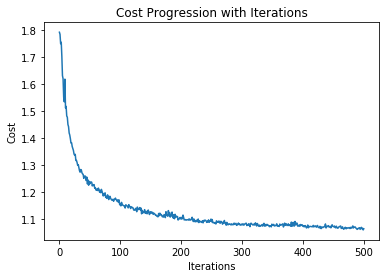

Train Accuracy:  97.7450966835022
Test Accuracy:  92.77777671813965
Max Test Accuracy: 96.11111283302307 on iteration 365
Learning rate:  0.009
Keep probability:  0.7
Time elapsed :  11.140306782722472
**********Learning rate******0.009********Keep prob***********0.8
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.20000000298023224
Accuracy Test: 0.2 on iteration 0
Cost is 1.7918481 for iteration: 0
Accuracy Test: 0.17777778 on iteration 1
Cost is 1.7781571 for iteration: 1
Accuracy Test: 0.15 on iteration 2
Cost is 1.7666699 for iteration: 2
Max till now is  

Accuracy Test: 0.8333333 on iteration 85
Cost is 1.1525799 for iteration: 85
Accuracy Test: 0.8333333 on iteration 86
Cost is 1.1440413 for iteration: 86
Accuracy Test: 0.85 on iteration 87
Cost is 1.1385292 for iteration: 87
Max till now is  0.8722222447395325
Accuracy Test: 0.87222224 on iteration 88
Cost is 1.1483603 for iteration: 88
Accuracy Test: 0.84444445 on iteration 89
Cost is 1.142329 for iteration: 89
Accuracy Test: 0.8277778 on iteration 90
Cost is 1.145239 for iteration: 90
Accuracy Test: 0.8333333 on iteration 91
Cost is 1.1458342 for iteration: 91
Accuracy Test: 0.85 on iteration 92
Cost is 1.1383753 for iteration: 92
Accuracy Test: 0.8388889 on iteration 93
Cost is 1.1425177 for iteration: 93
Accuracy Test: 0.8611111 on iteration 94
Cost is 1.1322201 for iteration: 94
Accuracy Test: 0.8 on iteration 95
Cost is 1.1390789 for iteration: 95
Accuracy Test: 0.82222223 on iteration 96
Cost is 1.1304661 for iteration: 96
Accuracy Test: 0.8388889 on iteration 97
Cost is 1.1459

Accuracy Test: 0.9 on iteration 188
Cost is 1.0846659 for iteration: 188
Accuracy Test: 0.9111111 on iteration 189
Cost is 1.0848511 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0930636 for iteration: 190
Accuracy Test: 0.8888889 on iteration 191
Cost is 1.0889027 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.0895946 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0839221 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0936227 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0859872 for iteration: 195
Accuracy Test: 0.9 on iteration 196
Cost is 1.0866345 for iteration: 196
Accuracy Test: 0.89444447 on iteration 197
Cost is 1.0818225 for iteration: 197
Accuracy Test: 0.8888889 on iteration 198
Cost is 1.0834403 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0820606 for iteration: 199
Accuracy Test: 0.89444447 on iteration 200
Cost is 1.0803325 for it

Accuracy Test: 0.9166667 on iteration 291
Cost is 1.0637925 for iteration: 291
Accuracy Test: 0.92777777 on iteration 292
Cost is 1.0714719 for iteration: 292
Accuracy Test: 0.93333334 on iteration 293
Cost is 1.0686153 for iteration: 293
Accuracy Test: 0.9 on iteration 294
Cost is 1.0628175 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0709965 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0747026 for iteration: 296
Accuracy Test: 0.9 on iteration 297
Cost is 1.067503 for iteration: 297
Accuracy Test: 0.8888889 on iteration 298
Cost is 1.0716186 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0704753 for iteration: 299
Max till now is  0.9555555582046509
Accuracy Test: 0.95555556 on iteration 300
Cost is 1.0671089 for iteration: 300
Accuracy Test: 0.9111111 on iteration 301
Cost is 1.070883 for iteration: 301
Accuracy Test: 0.89444447 on iteration 302
Cost is 1.0728501 for iteration: 302
Accuracy Test: 0.888888

Accuracy Test: 0.9222222 on iteration 395
Cost is 1.062657 for iteration: 395
Accuracy Test: 0.9166667 on iteration 396
Cost is 1.0632774 for iteration: 396
Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0574315 for iteration: 397
Accuracy Test: 0.9222222 on iteration 398
Cost is 1.0614922 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0610951 for iteration: 399
Accuracy Test: 0.95 on iteration 400
Cost is 1.0613631 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0642787 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.059023 for iteration: 402
Accuracy Test: 0.93333334 on iteration 403
Cost is 1.0604917 for iteration: 403
Accuracy Test: 0.9166667 on iteration 404
Cost is 1.0573359 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.0607073 for iteration: 405
Accuracy Test: 0.92777777 on iteration 406
Cost is 1.0619482 for iteration: 406
Accuracy Test: 0.9388889 on iteration 407
Cost is 1.06

Accuracy Test: 0.9111111 on iteration 499
Cost is 1.0542303 for iteration: 499
Accuracy Test: 0.9166667 on iteration 500
Cost is 1.0554863 for iteration: 500


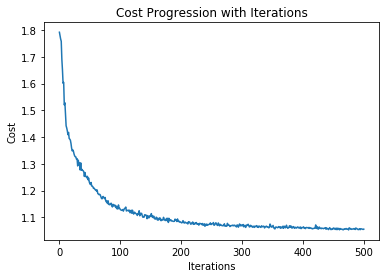

Train Accuracy:  98.92156720161438
Test Accuracy:  91.66666865348816
Max Test Accuracy: 96.66666388511658 on iteration 445
Learning rate:  0.009
Keep probability:  0.8
Time elapsed :  11.285209619998932
**********Learning rate******0.009********Keep prob***********0.9
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920426 for iteration: 0
Max till now is  0.25
Accuracy Test: 0.25 on iteration 1
Cost is 1.7792587 for iteration: 1
Max till now is  0.27222222089767456
Accuracy Test: 0.27222222 

Accuracy Test: 0.87222224 on iteration 86
Cost is 1.1337003 for iteration: 86
Accuracy Test: 0.87222224 on iteration 87
Cost is 1.1282175 for iteration: 87
Accuracy Test: 0.8666667 on iteration 88
Cost is 1.1310107 for iteration: 88
Max till now is  0.894444465637207
Accuracy Test: 0.89444447 on iteration 89
Cost is 1.1246114 for iteration: 89
Accuracy Test: 0.85 on iteration 90
Cost is 1.1250522 for iteration: 90
Accuracy Test: 0.8833333 on iteration 91
Cost is 1.1273247 for iteration: 91
Accuracy Test: 0.85555553 on iteration 92
Cost is 1.1297935 for iteration: 92
Accuracy Test: 0.8333333 on iteration 93
Cost is 1.1180583 for iteration: 93
Accuracy Test: 0.8666667 on iteration 94
Cost is 1.12089 for iteration: 94
Accuracy Test: 0.8611111 on iteration 95
Cost is 1.1152924 for iteration: 95
Accuracy Test: 0.87222224 on iteration 96
Cost is 1.1152068 for iteration: 96
Accuracy Test: 0.87222224 on iteration 97
Cost is 1.1253883 for iteration: 97
Accuracy Test: 0.85 on iteration 98
Cost i

Accuracy Test: 0.92777777 on iteration 188
Cost is 1.0671983 for iteration: 188
Accuracy Test: 0.93333334 on iteration 189
Cost is 1.0695679 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0735114 for iteration: 190
Accuracy Test: 0.8888889 on iteration 191
Cost is 1.0665786 for iteration: 191
Accuracy Test: 0.9388889 on iteration 192
Cost is 1.0694327 for iteration: 192
Accuracy Test: 0.87777776 on iteration 193
Cost is 1.0648397 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0709305 for iteration: 194
Accuracy Test: 0.9166667 on iteration 195
Cost is 1.0711135 for iteration: 195
Accuracy Test: 0.9166667 on iteration 196
Cost is 1.0699672 for iteration: 196
Accuracy Test: 0.92777777 on iteration 197
Cost is 1.0696807 for iteration: 197
Accuracy Test: 0.9388889 on iteration 198
Cost is 1.0671716 for iteration: 198
Accuracy Test: 0.9222222 on iteration 199
Cost is 1.0654427 for iteration: 199
Accuracy Test: 0.9 on iteration 200
Cost is 1.06

Accuracy Test: 0.95555556 on iteration 291
Cost is 1.0576859 for iteration: 291
Accuracy Test: 0.92777777 on iteration 292
Cost is 1.056033 for iteration: 292
Accuracy Test: 0.90555555 on iteration 293
Cost is 1.0552254 for iteration: 293
Accuracy Test: 0.9444444 on iteration 294
Cost is 1.0588509 for iteration: 294
Accuracy Test: 0.9388889 on iteration 295
Cost is 1.0545669 for iteration: 295
Accuracy Test: 0.92777777 on iteration 296
Cost is 1.0564302 for iteration: 296
Accuracy Test: 0.95 on iteration 297
Cost is 1.0591887 for iteration: 297
Accuracy Test: 0.9111111 on iteration 298
Cost is 1.0556754 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0595782 for iteration: 299
Accuracy Test: 0.9111111 on iteration 300
Cost is 1.0591106 for iteration: 300
Accuracy Test: 0.95 on iteration 301
Cost is 1.0549017 for iteration: 301
Accuracy Test: 0.95 on iteration 302
Cost is 1.0575747 for iteration: 302
Accuracy Test: 0.9166667 on iteration 303
Cost is 1.058005 for 

Accuracy Test: 0.9388889 on iteration 395
Cost is 1.055119 for iteration: 395
Accuracy Test: 0.9222222 on iteration 396
Cost is 1.0558358 for iteration: 396
Accuracy Test: 0.93333334 on iteration 397
Cost is 1.052815 for iteration: 397
Accuracy Test: 0.9388889 on iteration 398
Cost is 1.0575551 for iteration: 398
Accuracy Test: 0.9388889 on iteration 399
Cost is 1.0513273 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0532758 for iteration: 400
Accuracy Test: 0.95 on iteration 401
Cost is 1.0572093 for iteration: 401
Accuracy Test: 0.95555556 on iteration 402
Cost is 1.0524625 for iteration: 402
Accuracy Test: 0.9222222 on iteration 403
Cost is 1.0578381 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0552115 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.0549204 for iteration: 405
Accuracy Test: 0.9444444 on iteration 406
Cost is 1.0599949 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0

Accuracy Test: 0.9388889 on iteration 500
Cost is 1.0499512 for iteration: 500


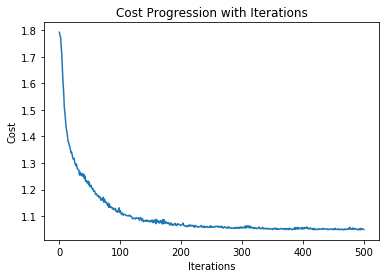

Train Accuracy:  99.21568632125854
Test Accuracy:  93.88889074325562
Max Test Accuracy: 96.66666388511658 on iteration 340
Learning rate:  0.009
Keep probability:  0.9
Time elapsed :  11.186961948871613
**********Learning rate******0.012********Keep prob***********0.7
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 0
Cost is 1.7917598 for iteration: 0
Max till now is  0.20555555820465088
Accuracy Test: 0.20555556 on iteration 1
Cost is 1.7920185 for iteration: 1
Accuracy Test: 0.15555556 on iteration 2
Co

Accuracy Test: 0.78333336 on iteration 86
Cost is 1.1689223 for iteration: 86
Accuracy Test: 0.8333333 on iteration 87
Cost is 1.1627758 for iteration: 87
Accuracy Test: 0.8388889 on iteration 88
Cost is 1.160387 for iteration: 88
Accuracy Test: 0.8055556 on iteration 89
Cost is 1.1636436 for iteration: 89
Accuracy Test: 0.84444445 on iteration 90
Cost is 1.1596756 for iteration: 90
Accuracy Test: 0.79444444 on iteration 91
Cost is 1.1559477 for iteration: 91
Accuracy Test: 0.84444445 on iteration 92
Cost is 1.1517981 for iteration: 92
Accuracy Test: 0.8277778 on iteration 93
Cost is 1.1589669 for iteration: 93
Accuracy Test: 0.8 on iteration 94
Cost is 1.1490796 for iteration: 94
Accuracy Test: 0.8277778 on iteration 95
Cost is 1.1493753 for iteration: 95
Accuracy Test: 0.84444445 on iteration 96
Cost is 1.1445274 for iteration: 96
Accuracy Test: 0.8333333 on iteration 97
Cost is 1.1432484 for iteration: 97
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 98
C

Accuracy Test: 0.85 on iteration 187
Cost is 1.0975926 for iteration: 187
Accuracy Test: 0.8888889 on iteration 188
Cost is 1.0947055 for iteration: 188
Accuracy Test: 0.89444447 on iteration 189
Cost is 1.0979851 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.09496 for iteration: 190
Accuracy Test: 0.9166667 on iteration 191
Cost is 1.0908029 for iteration: 191
Accuracy Test: 0.87777776 on iteration 192
Cost is 1.1136703 for iteration: 192
Accuracy Test: 0.9 on iteration 193
Cost is 1.0999955 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0957005 for iteration: 194
Accuracy Test: 0.87777776 on iteration 195
Cost is 1.1037282 for iteration: 195
Accuracy Test: 0.8888889 on iteration 196
Cost is 1.0984926 for iteration: 196
Accuracy Test: 0.87777776 on iteration 197
Cost is 1.0933087 for iteration: 197
Accuracy Test: 0.9166667 on iteration 198
Cost is 1.0917267 for iteration: 198
Accuracy Test: 0.8888889 on iteration 199
Cost is 1.0876156 for iteration

Accuracy Test: 0.90555555 on iteration 290
Cost is 1.0786115 for iteration: 290
Accuracy Test: 0.9222222 on iteration 291
Cost is 1.0764053 for iteration: 291
Accuracy Test: 0.95 on iteration 292
Cost is 1.0682161 for iteration: 292
Accuracy Test: 0.9388889 on iteration 293
Cost is 1.0819813 for iteration: 293
Accuracy Test: 0.92777777 on iteration 294
Cost is 1.0734751 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0758827 for iteration: 295
Accuracy Test: 0.8888889 on iteration 296
Cost is 1.0719985 for iteration: 296
Accuracy Test: 0.8888889 on iteration 297
Cost is 1.0776376 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0801072 for iteration: 298
Accuracy Test: 0.9444444 on iteration 299
Cost is 1.0732853 for iteration: 299
Accuracy Test: 0.92777777 on iteration 300
Cost is 1.0764 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0704637 for iteration: 301
Accuracy Test: 0.9111111 on iteration 302
Cost is 1.073

Accuracy Test: 0.95555556 on iteration 394
Cost is 1.0664237 for iteration: 394
Accuracy Test: 0.92777777 on iteration 395
Cost is 1.0678117 for iteration: 395
Accuracy Test: 0.9111111 on iteration 396
Cost is 1.0676578 for iteration: 396
Accuracy Test: 0.92777777 on iteration 397
Cost is 1.0657334 for iteration: 397
Max till now is  0.9722222089767456
Accuracy Test: 0.9722222 on iteration 398
Cost is 1.069169 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0674907 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.0643696 for iteration: 400
Accuracy Test: 0.9388889 on iteration 401
Cost is 1.070362 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0679879 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.0669552 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0684431 for iteration: 404
Accuracy Test: 0.95555556 on iteration 405
Cost is 1.0666595 for iteration: 405
Accuracy Test: 0.

Accuracy Test: 0.9222222 on iteration 498
Cost is 1.0691285 for iteration: 498
Accuracy Test: 0.9166667 on iteration 499
Cost is 1.067248 for iteration: 499
Accuracy Test: 0.95555556 on iteration 500
Cost is 1.0701485 for iteration: 500


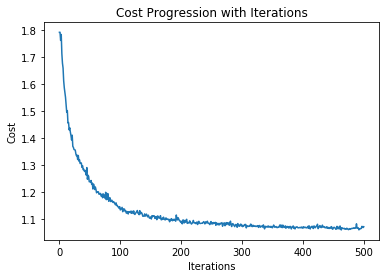

Train Accuracy:  98.43137264251709
Test Accuracy:  95.55555582046509
Max Test Accuracy: 97.22222089767456 on iteration 398
Learning rate:  0.012
Keep probability:  0.7
Time elapsed :  11.365768027305602
**********Learning rate******0.012********Keep prob***********0.8
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7918481 for iteration: 0
Accuracy Test: 0.17222223 on iteration 1
Cost is 1.785564 for iteration: 1
Max till now is  0.18888889253139496
Accuracy Test: 0.18888889 on iteration 2
Co

Accuracy Test: 0.8277778 on iteration 86
Cost is 1.1406324 for iteration: 86
Accuracy Test: 0.82222223 on iteration 87
Cost is 1.1421912 for iteration: 87
Max till now is  0.8833333253860474
Accuracy Test: 0.8833333 on iteration 88
Cost is 1.1383257 for iteration: 88
Accuracy Test: 0.8666667 on iteration 89
Cost is 1.1422399 for iteration: 89
Accuracy Test: 0.85 on iteration 90
Cost is 1.1394877 for iteration: 90
Accuracy Test: 0.84444445 on iteration 91
Cost is 1.1422124 for iteration: 91
Accuracy Test: 0.87222224 on iteration 92
Cost is 1.143125 for iteration: 92
Accuracy Test: 0.84444445 on iteration 93
Cost is 1.1389264 for iteration: 93
Accuracy Test: 0.8611111 on iteration 94
Cost is 1.1326905 for iteration: 94
Accuracy Test: 0.82222223 on iteration 95
Cost is 1.1288037 for iteration: 95
Accuracy Test: 0.8277778 on iteration 96
Cost is 1.1394057 for iteration: 96
Accuracy Test: 0.8333333 on iteration 97
Cost is 1.1356914 for iteration: 97
Accuracy Test: 0.84444445 on iteration 98

Accuracy Test: 0.9111111 on iteration 189
Cost is 1.080018 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0915563 for iteration: 190
Accuracy Test: 0.87222224 on iteration 191
Cost is 1.0836095 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.0843205 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.0824182 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0855405 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0840449 for iteration: 195
Accuracy Test: 0.8666667 on iteration 196
Cost is 1.0895332 for iteration: 196
Accuracy Test: 0.87777776 on iteration 197
Cost is 1.090068 for iteration: 197
Accuracy Test: 0.9166667 on iteration 198
Cost is 1.0792046 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0807084 for iteration: 199
Accuracy Test: 0.9 on iteration 200
Cost is 1.0809582 for iteration: 200
Max till now is  0.9333333373069763
Accuracy Test: 0.93333334 on itera

Accuracy Test: 0.9222222 on iteration 293
Cost is 1.0715623 for iteration: 293
Accuracy Test: 0.92777777 on iteration 294
Cost is 1.0723982 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0670949 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0667219 for iteration: 296
Accuracy Test: 0.9 on iteration 297
Cost is 1.0728819 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0690912 for iteration: 298
Accuracy Test: 0.90555555 on iteration 299
Cost is 1.067405 for iteration: 299
Accuracy Test: 0.93333334 on iteration 300
Cost is 1.0672755 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0669563 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0621836 for iteration: 302
Accuracy Test: 0.9166667 on iteration 303
Cost is 1.0680323 for iteration: 303
Accuracy Test: 0.9166667 on iteration 304
Cost is 1.0662699 for iteration: 304
Accuracy Test: 0.90555555 on iteration 305
Cost is 1.

Accuracy Test: 0.9111111 on iteration 396
Cost is 1.0601033 for iteration: 396
Accuracy Test: 0.9166667 on iteration 397
Cost is 1.0675825 for iteration: 397
Accuracy Test: 0.93333334 on iteration 398
Cost is 1.0599447 for iteration: 398
Accuracy Test: 0.8888889 on iteration 399
Cost is 1.0599073 for iteration: 399
Accuracy Test: 0.95555556 on iteration 400
Cost is 1.0662977 for iteration: 400
Accuracy Test: 0.93333334 on iteration 401
Cost is 1.0631969 for iteration: 401
Accuracy Test: 0.9166667 on iteration 402
Cost is 1.0658532 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0568148 for iteration: 403
Accuracy Test: 0.9388889 on iteration 404
Cost is 1.0597864 for iteration: 404
Accuracy Test: 0.90555555 on iteration 405
Cost is 1.0630553 for iteration: 405
Accuracy Test: 0.9222222 on iteration 406
Cost is 1.0649949 for iteration: 406
Accuracy Test: 0.95 on iteration 407
Cost is 1.0576856 for iteration: 407
Accuracy Test: 0.92777777 on iteration 408
Cost is 1.

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0547923 for iteration: 500


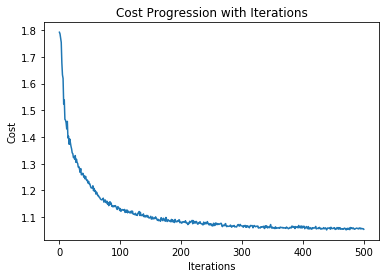

Train Accuracy:  98.92156720161438
Test Accuracy:  93.33333373069763
Max Test Accuracy: 95.55555582046509 on iteration 349
Learning rate:  0.012
Keep probability:  0.8
Time elapsed :  11.386085148652395
**********Learning rate******0.012********Keep prob***********0.9
Tensor("dropout/mul:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.23333333432674408
Accuracy Test: 0.23333333 on iteration 0
Cost is 1.7920426 for iteration: 0
Accuracy Test: 0.13333334 on iteration 1
Cost is 1.7902663 for iteration: 1
Max till now is  0.3222222328186035
Accuracy Test: 0.32222223 on iteration 2
Co

Accuracy Test: 0.84444445 on iteration 86
Cost is 1.1426167 for iteration: 86
Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.1510955 for iteration: 87
Accuracy Test: 0.8333333 on iteration 88
Cost is 1.1369686 for iteration: 88
Accuracy Test: 0.84444445 on iteration 89
Cost is 1.1429619 for iteration: 89
Accuracy Test: 0.79444444 on iteration 90
Cost is 1.1390773 for iteration: 90
Max till now is  0.8666666746139526
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.1510053 for iteration: 91
Accuracy Test: 0.85 on iteration 92
Cost is 1.1363078 for iteration: 92
Accuracy Test: 0.85 on iteration 93
Cost is 1.1341434 for iteration: 93
Accuracy Test: 0.82222223 on iteration 94
Cost is 1.1259724 for iteration: 94
Accuracy Test: 0.85 on iteration 95
Cost is 1.1256804 for iteration: 95
Accuracy Test: 0.85555553 on iteration 96
Cost is 1.122418 for iteration: 96
Accuracy Test: 0.85555553 on iteration 97
Cost is 1.1271944 for iteration: 97
Accuracy Test:

Accuracy Test: 0.89444447 on iteration 188
Cost is 1.0721517 for iteration: 188
Accuracy Test: 0.8666667 on iteration 189
Cost is 1.0731134 for iteration: 189
Accuracy Test: 0.89444447 on iteration 190
Cost is 1.0729898 for iteration: 190
Accuracy Test: 0.9222222 on iteration 191
Cost is 1.080132 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0780573 for iteration: 192
Accuracy Test: 0.87222224 on iteration 193
Cost is 1.0738169 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.071944 for iteration: 194
Accuracy Test: 0.9 on iteration 195
Cost is 1.0688223 for iteration: 195
Accuracy Test: 0.90555555 on iteration 196
Cost is 1.0819551 for iteration: 196
Accuracy Test: 0.89444447 on iteration 197
Cost is 1.0707326 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0695198 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0739205 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1

Accuracy Test: 0.9111111 on iteration 292
Cost is 1.0582014 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0581751 for iteration: 293
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 294
Cost is 1.0565184 for iteration: 294
Accuracy Test: 0.9388889 on iteration 295
Cost is 1.064026 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0582379 for iteration: 296
Accuracy Test: 0.9 on iteration 297
Cost is 1.056557 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0544909 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0548086 for iteration: 299
Accuracy Test: 0.9111111 on iteration 300
Cost is 1.0570172 for iteration: 300
Accuracy Test: 0.90555555 on iteration 301
Cost is 1.0567291 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0586997 for iteration: 302
Accuracy Test: 0.9111111 on iteration 303
Cost is 1.0583107 for iteration: 303
Accuracy Test: 0.90555555 on iterat

Accuracy Test: 0.9111111 on iteration 396
Cost is 1.052099 for iteration: 396
Accuracy Test: 0.9 on iteration 397
Cost is 1.0567681 for iteration: 397
Accuracy Test: 0.9222222 on iteration 398
Cost is 1.0522485 for iteration: 398
Accuracy Test: 0.90555555 on iteration 399
Cost is 1.0544289 for iteration: 399
Accuracy Test: 0.9166667 on iteration 400
Cost is 1.049659 for iteration: 400
Accuracy Test: 0.9166667 on iteration 401
Cost is 1.0543498 for iteration: 401
Accuracy Test: 0.9388889 on iteration 402
Cost is 1.0525938 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.0503738 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.052019 for iteration: 404
Accuracy Test: 0.9166667 on iteration 405
Cost is 1.0537739 for iteration: 405
Accuracy Test: 0.90555555 on iteration 406
Cost is 1.0518612 for iteration: 406
Accuracy Test: 0.9166667 on iteration 407
Cost is 1.0506296 for iteration: 407
Accuracy Test: 0.9166667 on iteration 408
Cost is 1.049792

In [ ]:
for learning_rate in [0.011, 0.009,0.012]:
    for keep_prob in [0.7,0.8, 0.9]:
        print("**********Learning rate******{}********Keep prob***********{}".format(learning_rate, keep_prob))
        train_cnn_lenet5(500, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, learning_rate, keep_prob)

### 5. (20pts) Predictions